<a href="https://colab.research.google.com/github/festa78/colab_experiments/blob/master/one_neuron_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from functools import partial
import typing

import matplotlib.pyplot as plt
import numpy as np
import torch

In [0]:
# Constants.
NUM_INPUT_DIM = 2

In [0]:
def sample_unitball(shape: typing.Tuple[int]) -> np.array:
  while True:
    sample = np.random.rand(*shape) * 2. - 1.
    if np.linalg.norm(sample) <= 1.:
      return sample

def create_dataset(num_samples: int) -> typing.Dict[str, np.array]:
  RADIUS = 3.
  POSITIVE_THRESHOLD = 1.
  NEGATIVE_THRESHOLD = 2.

  input_list = []
  label_list = []
  while len(input_list) < num_samples:
    sample = sample_unitball((1, NUM_INPUT_DIM)) * RADIUS
    if np.linalg.norm(sample) > POSITIVE_THRESHOLD and np.linalg.norm(sample) < NEGATIVE_THRESHOLD:
      continue

    input_list.append(sample)

    if np.linalg.norm(sample) <= POSITIVE_THRESHOLD:
      label_list.append(1)
    else:
      label_list.append(0)

  dataset = {
      'input': np.vstack(input_list),
      'label': np.array(label_list),
  }
  return dataset

test_data = create_dataset(100)
assert np.shape(test_data['input']) == (100, 2)
assert np.shape(test_data['label']) == (100,)
assert np.unique(test_data['label']).tolist() == [0 ,1]
for i, label in enumerate(test_data['label']):
  if label == 1:
    assert np.linalg.norm(test_data['input'][i]) <= 1.
  else:
    assert 2 <= np.linalg.norm(test_data['input'][i]) <= 3.

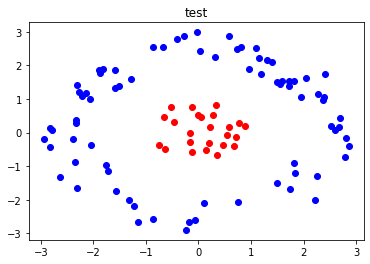

In [4]:
def scatter_on_ax(dataset: typing.Dict[str, np.array], ax, title):
  x1 = dataset['input'][dataset['label'] == 1, 0]
  y1 = dataset['input'][dataset['label'] == 1, 1]
  x2 = dataset['input'][dataset['label'] == 0, 0]
  y2 = dataset['input'][dataset['label'] == 0, 1]
  ax.scatter(x1, y1, c='red')
  ax.scatter(x2, y2, c='blue')
  ax.set_title(title)

def create_dataset_plot(dataset: typing.Dict[str, np.array], title):
  fig = plt.figure()
  scatter_on_ax(dataset, fig.add_subplot(1,1,1), title)
  fig.show()

create_dataset_plot(create_dataset(100), 'test')

In [0]:
class fully_connected_nn(torch.nn.Module):
  def __init__(self, num_hidden_layers=5):
    super().__init__()
    self.num_hidden_layers = num_hidden_layers    
    self._fc_nn_blocks = torch.nn.ModuleList(self._fc_nn_block() for _ in range(num_hidden_layers))
    self._fc_nn_block_final = self._fc_nn_block()

  @staticmethod
  def _fc_nn_block():
    return torch.nn.modules.Sequential(
        torch.nn.Linear(NUM_INPUT_DIM, NUM_INPUT_DIM),
        torch.nn.ReLU(),
        torch.nn.Linear(NUM_INPUT_DIM, NUM_INPUT_DIM),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    result = x
    for block in self._fc_nn_blocks:
      result = block(result)
    return self._fc_nn_block_final(result)

test_model = fully_connected_nn()
assert test_model(torch.rand((100, 2))).size() == torch.Size((100, 2))

In [0]:
class one_neuron_resnet(torch.nn.Module):
  def __init__(self, num_hidden_layers=5):
    super().__init__()
    self.num_hidden_layers = num_hidden_layers
    self._one_neuron_nn_blocks = torch.nn.ModuleList(self._one_neuron_nn_block() for _ in range(num_hidden_layers))
    self._one_neuron_nn_block_final = self._one_neuron_nn_block()

  @staticmethod
  def _one_neuron_nn_block() -> torch.nn.modules.container.Sequential:
    return torch.nn.modules.Sequential(
        torch.nn.Linear(NUM_INPUT_DIM, 1),
        torch.nn.ReLU(),
        torch.nn.Linear(1, NUM_INPUT_DIM),
    )

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    result = x
    for block in self._one_neuron_nn_blocks:
      result = block(result) + result
    return self._one_neuron_nn_block_final(result)

test_model = one_neuron_resnet()
assert test_model(torch.rand((100, 2))).size() == torch.Size((100, 2))

In [15]:
def train(dataset: typing.Dict[str, torch.Tensor], model_fn: torch.nn.Module, num_epochs: int = 100, learning_rate: float = 1.e-4) -> torch.nn.modules.container.Sequential:
  model = model_fn()
  criterion = torch.nn.CrossEntropyLoss()
  # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  for i in range(num_epochs):
    y_pred = model(dataset['input'])
    loss = criterion(y_pred, dataset['label'])
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  print('Model: {}, # of hidden layers: {}, Loss: {}'.format(model.__class__.__name__, model.num_hidden_layers, loss.item()))

  return model

print(train({'input': torch.randn(100, 2), 'label': torch.randint(2, (100,))}, fully_connected_nn, 2))
print(train({'input': torch.randn(100, 2), 'label': torch.randint(2, (100,))}, one_neuron_resnet, 2))

Model: fully_connected_nn, # of hidden layers: 5, Loss: 0.7072896361351013
fully_connected_nn(
  (_fc_nn_blocks): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=2, bias=True)
    )
    (1): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=2, bias=True)
    )
    (2): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=2, bias=True)
    )
    (3): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=2, bias=True)
    )
    (4): Sequential(
      (0): Linear(in_features=2, out_features=2, bias=True)
      (1): ReLU()
      (2): Linear(in_features=2, out_features=2, bias=True)
    )
  )
  (_fc_nn_block_final): Sequential(
    (0): 

Model: fully_connected_nn, # of hidden layers: 1, Loss: 0.7347818613052368
Model: fully_connected_nn, # of hidden layers: 2, Loss: 0.5604817867279053
Model: fully_connected_nn, # of hidden layers: 3, Loss: 0.855920672416687
Model: fully_connected_nn, # of hidden layers: 4, Loss: 0.5348257422447205
Model: fully_connected_nn, # of hidden layers: 5, Loss: 0.47342950105667114
Model: one_neuron_resnet, # of hidden layers: 1, Loss: 0.6398089528083801
Model: one_neuron_resnet, # of hidden layers: 2, Loss: 0.9340004920959473
Model: one_neuron_resnet, # of hidden layers: 3, Loss: 1.2471816539764404
Model: one_neuron_resnet, # of hidden layers: 4, Loss: 0.5087934732437134
Model: one_neuron_resnet, # of hidden layers: 5, Loss: 0.9537074565887451


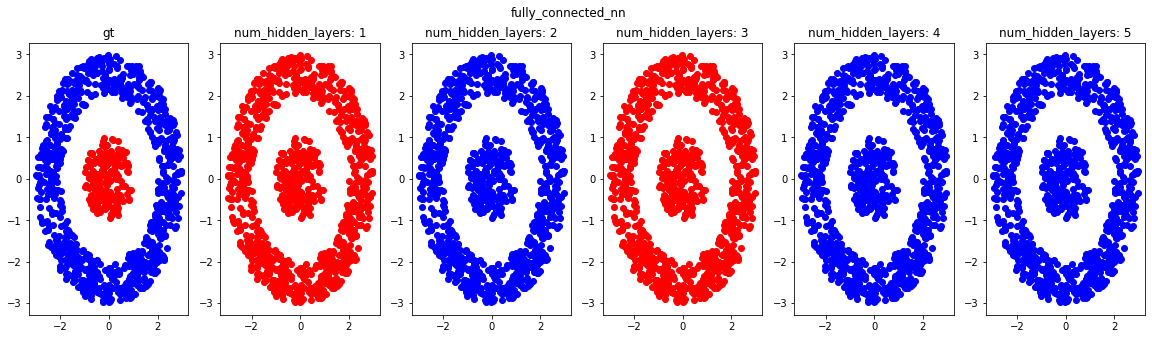

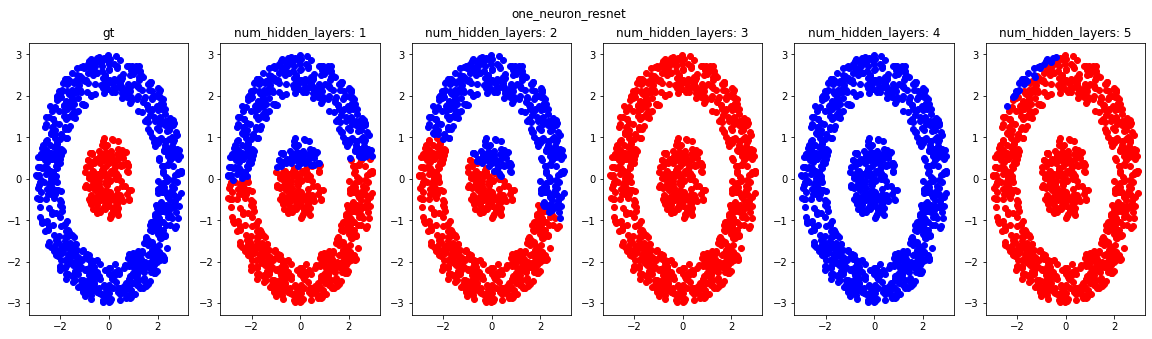

In [21]:
def convert_to_torch_dataset(dataset: typing.Dict[str, np.array]) -> typing.Dict[str, torch.Tensor]:
  return {
      'input': torch.from_numpy(dataset['input']).float(),
      'label': torch.from_numpy(dataset['label']).long(),
  }

def main(max_num_hidden_layers: int = 5, num_samples: int = 1000, num_epochs: int = 200, learning_rate: float = 1.e-4):
  dataset = create_dataset(num_samples)
  
  for model_fn in (fully_connected_nn, one_neuron_resnet):
    fig = plt.figure(figsize=(20, 5))
    fig.suptitle(model_fn.__name__)
    num_plot_column = max_num_hidden_layers + 1
    scatter_on_ax(dataset, fig.add_subplot(1, num_plot_column, 1), 'gt')

    for num_hidden_layers in range(1, max_num_hidden_layers + 1):
      model = train(convert_to_torch_dataset(dataset), partial(model_fn, num_hidden_layers=num_hidden_layers), num_epochs)
      y_pred = model(convert_to_torch_dataset(dataset)['input']).argmax(dim=1).detach().numpy()
      scatter_on_ax({'input': dataset['input'], 'label': y_pred}, fig.add_subplot(1, num_plot_column, 1 + num_hidden_layers), 'num_hidden_layers: {}'.format(num_hidden_layers))

main()